Testing Empirical cumulative distribution in 2-D

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors

n=1000 #number data points
mean=[2,1] #mean
cov=[[0.2,0.05],[0.05,0.1]] #covariance matrix
x1,x2=np.random.multivariate_normal(mean,cov,n).T

#ax1 = plt.scatter(x1,x2)
y=np.zeros(n,)
for i in range(n):
    y[i]=np.sum((x1[i] > x1) & (x2[i] > x2))
y/=n^2

#fig = plt.figure(figsize=(12,8), dpi= 100)
#ax = fig.add_subplot(111, projection='3d')
hist, xedges, yedges = np.histogram2d(x1, x2, bins=100, range=[[-2, 4], [-2, 4]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.1 * np.ones_like(zpos)
dz = hist.ravel()

offset = dz + np.abs(dz.min())
fracs = offset.astype(float)/offset.max()
norm = colors.Normalize(fracs.min(), fracs.max())
color_values = cm.coolwarm(norm(fracs.tolist()))

#ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color=color_values)
#plt.show()

#plotX=meshgrid

#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#ax.plot_surface(x1,x2,y,cmap=cm.coolwarm)



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors

n=100 #number data points
mean=[0.056,0.029] #mean
cov=[[0.0225,-0.0038],[-0.0038,0.0016]] #covariance matrix
x1,x2=np.random.multivariate_normal(mean,cov,n).T

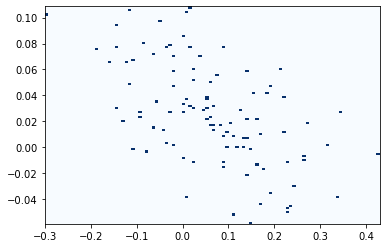

In [3]:
#ax1 = plt.scatter(x1,x2)
estimate= np.zeros(100,)
for mybin in range(100):
    y=np.zeros(n,)
    for i in range(n):
        y[i]=np.sum((x1[i] > x1) & (x2[i] > x2))
    y/=n
    hist_vals, xbins, ybins, mesh = plt.hist2d(x1, x2, bins=mybin+1, cmap='Blues')
    #plt.grid(b=True, which='major', color='#666666', linestyle='-')
    #plt.pcolormesh(xbins, ybins, hist_vals.cumsum(axis=0).cumsum(axis=1),cmap='Blues')

    #my expectation: expected value of x1 = integral over x1 (x1*p(x1) dx1) = integral over x1 (x1 integral over x2 p(x1,x2) dx2)

    mean_x1 = 0
    mean_x2 = 0
    I,_ =np.shape(hist_vals)
    for i in range(I):
            mean_x1 += sum(hist_vals[i,:])*xbins[i]
            mean_x2 += sum(hist_vals[:,i])*ybins[i]
    mean_x1 /= n
    mean_x2 /= n
    #print(mean_x1, mean_x2)
    #print(mean_x1/mean[0],mean_x2/mean[1])

    #so expectation.T = M @ [xbins,ybins], where M[i,:] = sum(hist_vals, axis=[all but i])

    #what if we add weights?

    #so expectation.T = M @ [bins_1,bins_2,...bins_i,...bins_d], where M[i,:] = sum(hist_vals, axis=[all but i])
    #maximise weighted sum of expectations:
    # max_w expectation.T @ w, subject to constraints:
    #prob of less than -10% return less than 5%
    #also no leveraging and weights add to one
    
    #number of decision variables: d
    #number of constraints: 1 for weight sum, 1 for no leverage, 1 constraint for hyperplane supporting risk points 

    mymesh=np.zeros((I,I))
    for i in range(I):
        for j in range(I):
            mymesh[i,j]=0.5*xbins[i]+0.5*ybins[j]

    estimate[mybin] = np.sum(np.ravel(hist_vals)[mymesh.ravel() <= -0.1])/n

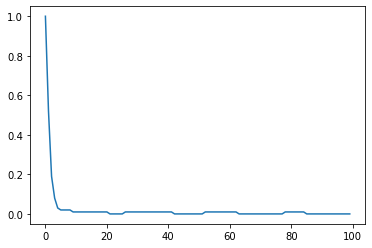

In [4]:
plt.plot(estimate[:100])

In [14]:
mean_x1
n

1000

In [12]:
#Let's build a MILP
from mip import *

d=2 #2-dimensional problem
alpha = 0.05 #significance level
n_activeCon = np.ceil(n*0.05) #number of active constraints

m = Model(solver_name=CBC) # use GRB for Gurobi
w = [ m.add_var() for i in range(d) ]
z = [ m.add_var(var_type=BINARY) for i in range(n) ]


#objective
m.objective = maximise(w[0]*mean_x1+w[1]*mean_x2)

#constaints
m += xsum(z[i] for i in range(n)) == n_activeCon